PyTerrier is a Python framework, but uses the underlying Terrier.org information retrieval toolkit for many indexing and retrieval operations. While PyTerrier was new in 2020, Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform IR experiments in Python, but using the mature Terrier platform for the expensive indexing and retrieval operations.

In [ ]:
!pip install python-terrier #installing PyTerrier


In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init() #initialise PyTerrier

In [3]:
vaswani_dataset = pt.get_dataset("vaswani")
index = pt.IndexFactory.of(vaswani_dataset.get_index())


data.direct.bf:   0%|          | 0.00/388k [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/234k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/362k [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/682k [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/777 [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/30.3k [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/725k [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/89.3k [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/224k [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.29k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/619 [00:00<?, ?iB/s]

In [5]:
#function to display the contents of the document using direct index
def get_document_direct(index, docno=None, docid=None):
  if docid is None and docno is None:
    raise ValueError("Must specify docno or docid")
  if docno is not None:
    docid = index.getMetaIndex().getDocument("docno", docno)
  else:
    docno = index.getMetaIndex().getItem("docno", docid)
  rtr = "Docno %s (docid %d)\n" % (docno, docid)
  pointer = index.getDocumentIndex().getDocumentEntry(docid)
  for p in index.getDirectIndex().getPostings(pointer):
    termid = p.getId()
    term = index.getLexicon()[termid].getKey()
    rtr += ("\t%s %d\n" % ( term, p.getFrequency()))
  return rtr

In [6]:
print(index.getCollectionStatistics()) #Statistics of the index
print(get_document_direct(index, docid=0))#Document index 0

Number of documents: 11429
Number of terms: 7756
Number of postings: 224573
Number of fields: 1
Number of tokens: 271581
Field names: [text]
Positions:   false

Docno 1 (docid 0)
	storag 1
	random 1
	flexibl 1
	data 1
	system 1
	compact 1
	sequenti 1
	digit 1
	memori 1
	bit 1
	access 1
	capac 2



In [7]:
#Single word query search using BatchRetrieve by specifying an index and a weighting model
br = pt.BatchRetrieve(index, wmodel="Tf")
br.search("document")

,qid,docid,docno,rank,score,query
0,1,2788,2789,0,2.0,document
1,1,3109,3110,1,1.0,document
2,1,6174,6175,2,1.0,document


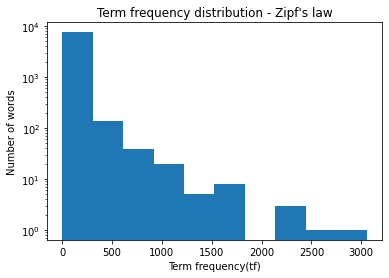

In [9]:
#Does Vaswani dataset follows Zipfian distribution? #yes it does
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

tf=defaultdict(list)
#index.getLexicon()["circuit"].getFrequency()

for id in index.getLexicon():
  term=id.getKey()
  tf["Terms"].append(id.getKey())
  tf["Frequency"].append(id.getValue().getFrequency())

term_frequency=pd.DataFrame(tf)  
term_frequency.shape

plt.hist(term_frequency["Frequency"],log=True)
plt.xlabel("Term frequency(tf)")
plt.ylabel("Number of words")
plt.title("Term frequency distribution - Zipf's law")
plt.show()
#plt.plot(a,b)
#plt.yscale("log")
#plt.show()


In [10]:
vaswani_dataset.get_topics().head(5) #queries

query-text.trec:   0%|          | 0.00/3.05k [00:00<?, ?iB/s]

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...


In [11]:
vaswani_dataset.get_qrels().head(4)

qrels:   0%|          | 0.00/6.63k [00:00<?, ?iB/s]

,qid,docno,label
0,1,1239,1
1,1,1502,1
2,1,4462,1
3,1,4569,1


In [12]:
query = vaswani_dataset.get_qrels().query('qid == ["4"]')
query.apply(lambda x: get_document_direct(index,x['docno']),axis=1)#relevant documents of query_id = '4'

67    Docno 2042 (docid 2041)\n\tdata 1\n\tprocess 2...
68    Docno 2180 (docid 2179)\n\tstorag 1\n\tdata 1\...
69    Docno 3595 (docid 3594)\n\tdata 1\n\tsystem 2\...
70    Docno 4057 (docid 4056)\n\tdata 1\n\tsystem 1\...
71    Docno 7985 (docid 7984)\n\tsystem 1\n\tdigit 1...
dtype: object

In [13]:
#using the TF_IDF model instead of TF for better document retreival
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

tfidf.transform(vaswani_dataset.get_topics().head(1))

,qid,docid,docno,rank,score,query
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids ...
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids ...
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids ...
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids ...
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids ...
...,...,...,...,...,...,...
995,1,9550,9551,995,2.646072,measurement of dielectric constant of liquids ...
996,1,11139,11140,996,2.646072,measurement of dielectric constant of liquids ...
997,1,11298,11299,997,2.646072,measurement of dielectric constant of liquids ...
998,1,3294,3295,998,2.644992,measurement of dielectric constant of liquids ...


In [14]:
#PyTerrier Transformers
#tfidf is a transformer...
print(isinstance(tfidf, pt.transformer.TransformerBase))
#Yes!

# this prints the type hierarchy of the TF_IDF class
tfidf.__class__.__mro__

True


(pyterrier.batchretrieve.BatchRetrieve,
 pyterrier.batchretrieve.BatchRetrieveBase,
 pyterrier.transformer.TransformerBase,
 matchpy.expressions.expressions.Symbol,
 matchpy.expressions.expressions.Atom,
 matchpy.expressions.expressions.Expression,
 object)

In [15]:
# this is the first retrieval transformer -
# it transform a queries dataframe to a results dataframe
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf( vaswani_dataset.get_topics().head(1) )

,qid,docid,docno,rank,score,query
0,1,7233,7234,0,9.0,measurement of dielectric constant of liquids ...
1,1,3692,3693,1,8.0,measurement of dielectric constant of liquids ...
2,1,5501,5502,2,7.0,measurement of dielectric constant of liquids ...
3,1,8907,8908,3,7.0,measurement of dielectric constant of liquids ...
4,1,3333,3334,4,6.0,measurement of dielectric constant of liquids ...
...,...,...,...,...,...,...
995,1,2271,2272,995,1.0,measurement of dielectric constant of liquids ...
996,1,2273,2274,996,1.0,measurement of dielectric constant of liquids ...
997,1,2286,2287,997,1.0,measurement of dielectric constant of liquids ...
998,1,2288,2289,998,1.0,measurement of dielectric constant of liquids ...


In [16]:
# defining a pipeline 
pipeline = tf >> tfidf
print(isinstance(tfidf, pt.transformer.TransformerBase))

pipeline( vaswani_dataset.get_topics().head(1))
#tf -> tf_idf

True


,qid,docid,docno,rank,score,query
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids ...
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids ...
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids ...
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids ...
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids ...
...,...,...,...,...,...,...
995,1,2124,2125,995,1.221881,measurement of dielectric constant of liquids ...
996,1,117,118,996,0.985003,measurement of dielectric constant of liquids ...
997,1,119,120,997,0.985003,measurement of dielectric constant of liquids ...
998,1,1239,1240,998,0.941543,measurement of dielectric constant of liquids ...


Creating a ranker that returns the top 10 scored documents based on the following retrieval model:
$$
score(d,Q) = \big( \sum_{t \in Q} w_{TF\_IDF}(t,d) \big)  + 3 * \sum_{t \in Q} tf_{t,d}
$$
In essence, this equation scores documents by linearly combining the scores of two different retrieval models. 


In [17]:
# YOUR SOLUTION #Task 4 a
queries = pd.DataFrame([["q1", "chemical"]], columns=["qid", "query"])

tf = pt.BatchRetrieve(index, wmodel="Tf")
tfidf= pt.BatchRetrieve(index, wmodel="TF_IDF")
res=(tfidf + 3 * tf).transform(queries)
res.head(10)

,qid,docid,docno,score,query,rank
0,q1,10702,10703,10.381090,chemical,1
1,q1,1055,1056,9.857900,chemical,2
2,q1,4885,4886,9.699605,chemical,3
3,q1,6278,6279,12.128197,chemical,0
4,q1,1139,1140,8.884626,chemical,4
5,q1,8765,8766,8.884626,chemical,5
6,q1,10138,10139,8.767690,chemical,6
7,q1,2519,2520,8.655311,chemical,7
8,q1,2557,2558,8.655311,chemical,8
9,q1,4686,4687,8.547228,chemical,9


Creating a ranker that performs the following:

 - obtains the top 10 highest scoring documents by term frequency (wmodel="Tf")
 - obtains the top 10 highest scoring documents by TF.IDF (wmodel="TF_IDF")
 - reranks only those documents found in BOTH of the previous retrieval settings using BM25.

How many documents are retrieved by this full pipeline for the query "chemical"

In [18]:
import pandas as pd
tf = pt.BatchRetrieve(index, wmodel="Tf")
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

pipeline=tfidf + 3 * tf

display(pipeline.search("chemical"))

#intersection
tf_rerank=pt.BatchRetrieve(index, wmodel="Tf",num_results=10)
tfidf_rerank=pt.BatchRetrieve(index, wmodel="TF_IDF",num_results=10)
bm=pt.BatchRetrieve(index, wmodel="BM25")

newpipeline=(tf_rerank & tfidf_rerank) >> bm
display(newpipeline.search("chemical"))

,qid,docid,docno,score,query,rank
3,1,6278,6279,12.128197,chemical,0
0,1,10702,10703,10.381090,chemical,1
1,1,1055,1056,9.857900,chemical,2
2,1,4885,4886,9.699605,chemical,3
4,1,1139,1140,8.884626,chemical,4
5,1,8765,8766,8.884626,chemical,5
6,1,10138,10139,8.767690,chemical,6
7,1,2519,2520,8.655311,chemical,7
8,1,2557,2558,8.655311,chemical,8
9,1,4686,4687,8.547228,chemical,9


,qid,docid,docno,rank,score,query
0,1,1055,1056,0,12.517082,chemical
1,1,6278,6279,1,11.185223,chemical
2,1,1139,1140,2,10.740657,chemical
3,1,2519,2520,3,10.322110,chemical
4,1,2557,2558,4,10.322110,chemical
5,1,4686,4687,5,10.124835,chemical


In [19]:
#Evaluation measures 
#success = Relevant Document at the first rank
qrels = vaswani_dataset.get_qrels()
def get_res_with_labels(ranker, df):
  #get the results for the query or queries
  results = ranker( df )
  # left outer join with the qrels
  with_labels = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
  return with_labels

#lets get the Tf results for the first query
get_res_with_labels(tf, vaswani_dataset.get_topics().head(1) )
#Got the relevant document on thrid ranking using TF

,qid,docid,docno,rank,score,query,label
0,1,7233,7234,0,9.0,measurement of dielectric constant of liquids ...,0.0
1,1,3692,3693,1,8.0,measurement of dielectric constant of liquids ...,0.0
2,1,5501,5502,2,7.0,measurement of dielectric constant of liquids ...,1.0
3,1,8907,8908,3,7.0,measurement of dielectric constant of liquids ...,0.0
4,1,3333,3334,4,6.0,measurement of dielectric constant of liquids ...,0.0
...,...,...,...,...,...,...,...
995,1,2271,2272,995,1.0,measurement of dielectric constant of liquids ...,0.0
996,1,2273,2274,996,1.0,measurement of dielectric constant of liquids ...,0.0
997,1,2286,2287,997,1.0,measurement of dielectric constant of liquids ...,0.0
998,1,2288,2289,998,1.0,measurement of dielectric constant of liquids ...,0.0


In [20]:
#lets get the tfidf results for the first query
get_res_with_labels(tfidf, vaswani_dataset.get_topics().head(1) )
#Got relevant document at first ranking

,qid,docid,docno,rank,score,query,label
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids ...,1.0
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids ...,0.0
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids ...,1.0
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids ...,1.0
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids ...,1.0
...,...,...,...,...,...,...,...
995,1,9550,9551,995,2.646072,measurement of dielectric constant of liquids ...,0.0
996,1,11139,11140,996,2.646072,measurement of dielectric constant of liquids ...,0.0
997,1,11298,11299,997,2.646072,measurement of dielectric constant of liquids ...,0.0
998,1,3294,3295,998,2.644992,measurement of dielectric constant of liquids ...,0.0


**Query Reformulation**
$$
score(d,Q) = \sum_{t \in Q} tf_{t,q} * tf_{t,d}
$$
where $tf_{t,d}$ is the frequency of the term in *document* and $tf_{t,q}$ is the frequency of the term in the *query*.

In [21]:
# here I try to change the emphasis on some words
newQueryDf = pd.DataFrame([
  ["1", "measurement^0.5 of dielectric^4 constant^0.4 of liquids^2 by "+
    "the use^0.1 of microwave^2 techniques^0.4"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf )

,qid,docid,docno,rank,score,query,label
0,1,7922,7923,0,4.625,measurement^0.5 of dielectric^4 constant^0.4 o...,1.0
1,1,9858,9859,1,4.600,measurement^0.5 of dielectric^4 constant^0.4 o...,1.0
2,1,3692,3693,2,4.400,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
3,1,7830,7831,3,4.100,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
4,1,7940,7941,4,4.100,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
...,...,...,...,...,...,...,...
995,1,10255,10256,995,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
996,1,10617,10618,996,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
997,1,10631,10632,997,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
998,1,10829,10830,998,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0


In [22]:
# here I try to change the emphasis on some words
newQueryDf = pd.DataFrame([
  ["1", "measurement^0.5 of dielectric^4 constant^0.4 of liquids^2 by "+
    "the use^0.1 of microwave^2 techniques^0.4"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf )

#rank 0 has label 1.0 for these term weights

,qid,docid,docno,rank,score,query,label
0,1,7922,7923,0,4.625,measurement^0.5 of dielectric^4 constant^0.4 o...,1.0
1,1,9858,9859,1,4.600,measurement^0.5 of dielectric^4 constant^0.4 o...,1.0
2,1,3692,3693,2,4.400,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
3,1,7830,7831,3,4.100,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
4,1,7940,7941,4,4.100,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
...,...,...,...,...,...,...,...
995,1,10255,10256,995,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
996,1,10617,10618,996,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
997,1,10631,10632,997,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
998,1,10829,10830,998,0.200,measurement^0.5 of dielectric^4 constant^0.4 o...,0.0
